In [1]:
# adhunter_v2
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np

In [ ]:
# Before running this code:
#
# A hmmer search was performed using the y1000+ genomes
#       Build hmm profile from ygob alignment of Ino2 genes: 
#               hmmbuild <hmmprofile> <ygob_alignment>
#       Run hmm search on genomes from y1000+:
#           cat ../genome_data/y1000p_pep_files_modified/*modified.pep | hmmsearch -o Ino4_search.out -A Ino4_search.align --tblout Ino4_search.tsv Ino4.hmm -
# 
# Extract significant genes found in hmmsearch using the get_gene_names function
# 
# Get sequences for significant genes
#       while IFS=, read -r gene species; do   species=$(echo "$species" | tr -d '\r');  grep -A 1 $gene ../GCN4_evolution/genome_data/y1000p_pep_files_modified/${species}_modified.pep; done < ino4_gene_names.csv > ino4_orthologs.fasta
# 
# Use the fasta file to identify domains with: https://www.ncbi.nlm.nih.gov/Structure/bwrpsb/bwrpsb.cgi
#
# Perform a reverse blast on the identified sequences with: 
#       ncbi-blast-2.15.0+/bin/blastp -query ino4_orthologs.fasta -db saccharomyces_cerevisiae.final.blastdb -evalue 0.001 -outfmt 6 > reciprocal_blast_ino4.txt

In [ ]:
# Used to extract gene names
def get_gene_names(in_file, out_file):
    with open(in_file, "r") as f:
        lines = f.readlines()
        
    genes = [line for line in lines if not line.startswith("#")]
    names = [gene.split()[0] for gene in genes]

    e_vals = [float(gene.split()[4]) for gene in genes]
    scores = [float(gene.split()[5]) for gene in genes]

    split_names = [name.split("_") for name in names]

    genes = [split_name[0] for split_name in split_names]
    species = ["_".join(split_name[1:]) for split_name in split_names]

    genes_species = pd.DataFrame((genes, species, e_vals, scores)).T
    genes_species.columns = ["gene","species","evalue", "scores"]
    genes_species = genes_species[genes_species["evalue"] < 0.001]

    genes_species[["gene", "species"]].to_csv(out_file, index=False, header=None)

# Domain filtering

In [2]:
all_lines = []

# Read in domain file
for i in range(1,4):
    domain_file = f"../Ino4/Ino4_domains_{i}.txt"
    with open(domain_file, "r") as f:
        lines = f.readlines()

    lines = [line.strip().split('\t') for line in lines if not line.startswith("#")]
    all_lines = all_lines + (lines[2:])

domains = pd.DataFrame(all_lines, columns=lines[1])
domains["name"] = [s.split('>')[-1] for s in domains["Query"]]
domains

,Query,Hit type,PSSM-ID,From,To,E-Value,Bitscore,Accession,Short name,Incomplete,Superfamily,name
0,Q#1 - >g000082.m1_yHDO603_zygosaccharomyces_sa...,superfamily,469605,59,125,5.74237e-22,85.2086,cl00081,bHLH_SF superfamily,-,-,g000082.m1_yHDO603_zygosaccharomyces_sapae_190...
1,Q#2 - >g001507.m1_yHMPu5000034863_zygosaccharo...,superfamily,469605,59,125,5.74237e-22,85.2086,cl00081,bHLH_SF superfamily,-,-,g001507.m1_yHMPu5000034863_zygosaccharomyces_r...
2,Q#3 - >g002198.m1_yHDO572_zygosaccharomyces_me...,superfamily,469605,58,124,1.13336e-24,92.1421,cl00081,bHLH_SF superfamily,-,-,g002198.m1_yHDO572_zygosaccharomyces_mellis_18...
3,Q#4 - >g006183.m1_yHDO603_zygosaccharomyces_sa...,superfamily,469605,60,126,5.73487e-24,89.8309,cl00081,bHLH_SF superfamily,-,-,g006183.m1_yHDO603_zygosaccharomyces_sapae_190...
4,Q#5 - >g004475.m1_yHMPu5000037836_zygosaccharo...,superfamily,469605,60,126,5.49291e-24,89.8309,cl00081,bHLH_SF superfamily,-,-,g004475.m1_yHMPu5000037836_zygosaccharomyces_p...
...,...,...,...,...,...,...,...,...,...,...,...,...
2152,Q#50 - >g003709.m1_yHMPu5000037918_alloascoide...,superfamily,469605,225,288,2.1986e-14,67.7102,cl00081,bHLH_SF superfamily,-,-,g003709.m1_yHMPu5000037918_alloascoidea_africa...
2153,Q#50 - >g003709.m1_yHMPu5000037918_alloascoide...,superfamily,401645,285,373,0.00106614,41.1748,cl37801,PAT1 superfamily,NC,-,g003709.m1_yHMPu5000037918_alloascoidea_africa...
2154,Q#51 - >g005186.m1_yHMPu5000035679_candida_rha...,superfamily,469605,358,385,0.000555393,38.435,cl00081,bHLH_SF superfamily,C,-,g005186.m1_yHMPu5000035679_candida_rhagii_1606...
2155,Q#52 - >g005901.m1_yHMPu5000035680_candida_pse...,superfamily,469605,358,385,0.000549962,38.435,cl00081,bHLH_SF superfamily,C,-,g005901.m1_yHMPu5000035680_candida_pseudorhagi...


In [3]:
# Identify cerevisiae domains
domains[["saccharomyces_cerevisiae" in s for s in domains["name"]]]

,Query,Hit type,PSSM-ID,From,To,E-Value,Bitscore,Accession,Short name,Incomplete,Superfamily,name
15,Q#16 - >YOL108C_saccharomyces_cerevisiae.sgd,superfamily,469605,45,60,0.00659455,31.1162,cl00081,bHLH_SF superfamily,C,-,YOL108C_saccharomyces_cerevisiae.sgd
16,Q#17 - >g002079.m1_saccharomyces_cerevisiae.final,specific,381409,45,115,1.38656e-32,110.247,cd11403,bHLH_scINO4_like,-,cl00081,g002079.m1_saccharomyces_cerevisiae.final


In [4]:
# Look at top most common domains
domains["Short name"].value_counts()

Short name
bHLH_SF superfamily       1939
bHLHzip_scCBP1              29
bHLH_scINO4_like            27
bHLHzip_MLXIP_like          24
PHA03247 superfamily        15
                          ... 
PHA03369 superfamily         1
Atrophin-1 superfamily       1
PRK13335 superfamily         1
PRK13735 superfamily         1
PRK14959 superfamily         1
Name: count, Length: 64, dtype: int64

In [5]:
# Filter for domains
dna_binding_domain = domains[(domains["Short name"] == "bHLH_SF superfamily") | (domains["Superfamily"] == "cl00081")]

In [6]:
# Get gene and species DF
genes_species = pd.read_csv("../Ino4/Ino4_gene_names.csv", header=None)
genes_species.columns = ["gene", "species"]
genes_species["name"] = genes_species["gene"] + "_" + genes_species["species"]
genes_species

,gene,species,name
0,g000082.m1,yHDO603_zygosaccharomyces_sapae_190924.haplome...,g000082.m1_yHDO603_zygosaccharomyces_sapae_190...
1,g001507.m1,yHMPu5000034863_zygosaccharomyces_rouxii_18060...,g001507.m1_yHMPu5000034863_zygosaccharomyces_r...
2,g002198.m1,yHDO572_zygosaccharomyces_mellis_180604.final,g002198.m1_yHDO572_zygosaccharomyces_mellis_18...
3,g006183.m1,yHDO603_zygosaccharomyces_sapae_190924.haplome...,g006183.m1_yHDO603_zygosaccharomyces_sapae_190...
4,g004475.m1,yHMPu5000037836_zygosaccharomyces_pseudorouxii...,g004475.m1_yHMPu5000037836_zygosaccharomyces_p...
...,...,...,...
2048,g002210.m1,yHMPu5000041772_sugiyamaella_chiloensis_170912...,g002210.m1_yHMPu5000041772_sugiyamaella_chiloe...
2049,g003709.m1,yHMPu5000037918_alloascoidea_africana_180604.f...,g003709.m1_yHMPu5000037918_alloascoidea_africa...
2050,g005186.m1,yHMPu5000035679_candida_rhagii_160613.final,g005186.m1_yHMPu5000035679_candida_rhagii_1606...
2051,g005901.m1,yHMPu5000035680_candida_pseudorhagii_160519.final,g005901.m1_yHMPu5000035680_candida_pseudorhagi...


In [8]:
# Merge domain df with gene/species name DF
dna_binding_domain = genes_species.merge(dna_binding_domain, on="name")
dna_binding_domain.drop_duplicates("name")

,gene,species,name,Query,Hit type,PSSM-ID,From,To,E-Value,Bitscore,Accession,Short name,Incomplete,Superfamily
0,g000082.m1,yHDO603_zygosaccharomyces_sapae_190924.haplome...,g000082.m1_yHDO603_zygosaccharomyces_sapae_190...,Q#1 - >g000082.m1_yHDO603_zygosaccharomyces_sa...,superfamily,469605,59,125,5.74237e-22,85.2086,cl00081,bHLH_SF superfamily,-,-
1,g001507.m1,yHMPu5000034863_zygosaccharomyces_rouxii_18060...,g001507.m1_yHMPu5000034863_zygosaccharomyces_r...,Q#2 - >g001507.m1_yHMPu5000034863_zygosaccharo...,superfamily,469605,59,125,5.74237e-22,85.2086,cl00081,bHLH_SF superfamily,-,-
2,g002198.m1,yHDO572_zygosaccharomyces_mellis_180604.final,g002198.m1_yHDO572_zygosaccharomyces_mellis_18...,Q#3 - >g002198.m1_yHDO572_zygosaccharomyces_me...,superfamily,469605,58,124,1.13336e-24,92.1421,cl00081,bHLH_SF superfamily,-,-
3,g006183.m1,yHDO603_zygosaccharomyces_sapae_190924.haplome...,g006183.m1_yHDO603_zygosaccharomyces_sapae_190...,Q#4 - >g006183.m1_yHDO603_zygosaccharomyces_sa...,superfamily,469605,60,126,5.73487e-24,89.8309,cl00081,bHLH_SF superfamily,-,-
4,g004475.m1,yHMPu5000037836_zygosaccharomyces_pseudorouxii...,g004475.m1_yHMPu5000037836_zygosaccharomyces_p...,Q#5 - >g004475.m1_yHMPu5000037836_zygosaccharo...,superfamily,469605,60,126,5.49291e-24,89.8309,cl00081,bHLH_SF superfamily,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2036,g002210.m1,yHMPu5000041772_sugiyamaella_chiloensis_170912...,g002210.m1_yHMPu5000041772_sugiyamaella_chiloe...,Q#49 - >g002210.m1_yHMPu5000041772_sugiyamaell...,superfamily,469605,166,227,2.29275e-15,70.0214,cl00081,bHLH_SF superfamily,-,-
2037,g003709.m1,yHMPu5000037918_alloascoidea_africana_180604.f...,g003709.m1_yHMPu5000037918_alloascoidea_africa...,Q#50 - >g003709.m1_yHMPu5000037918_alloascoide...,superfamily,469605,225,288,2.1986e-14,67.7102,cl00081,bHLH_SF superfamily,-,-
2038,g005186.m1,yHMPu5000035679_candida_rhagii_160613.final,g005186.m1_yHMPu5000035679_candida_rhagii_1606...,Q#51 - >g005186.m1_yHMPu5000035679_candida_rha...,superfamily,469605,358,385,0.000555393,38.435,cl00081,bHLH_SF superfamily,C,-
2039,g005901.m1,yHMPu5000035680_candida_pseudorhagii_160519.final,g005901.m1_yHMPu5000035680_candida_pseudorhagi...,Q#52 - >g005901.m1_yHMPu5000035680_candida_pse...,superfamily,469605,358,385,0.000549962,38.435,cl00081,bHLH_SF superfamily,C,-


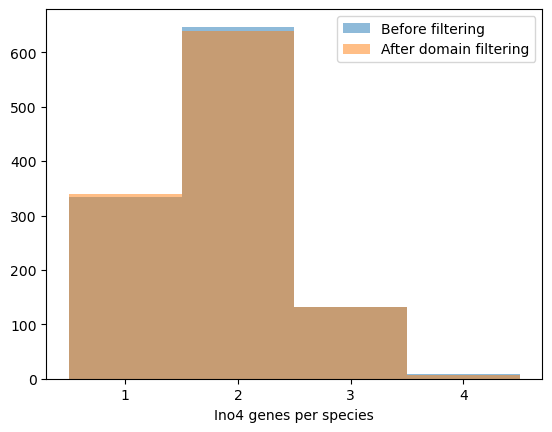

In [9]:
# Visualize genes per species
plt.hist(genes_species["species"].value_counts(), bins=[0.5, 1.5, 2.5, 3.5, 4.5], alpha=0.5, label="Before filtering")
plt.hist(dna_binding_domain["species"].value_counts(), bins=[0.5, 1.5, 2.5, 3.5, 4.5], alpha=0.5, label="After domain filtering")
plt.xticks([1,2,3,4])
plt.xlabel("Ino4 genes per species")
plt.legend()

# Reciprocal blast

In [10]:
# Read in blast data
blast_hits = pd.read_table("../Ino4/blast_Ino4.txt", header=None)
blast_hits.columns = ["gene_species_name", "blast_hit_gene_name","percent_identical", "alignment_length","num_mismatch","num_gaps","start_of_align_query","end_of_align_query","start_of_align_subj","end_of_align_subj","evalue","bitscore"]
blast_hits

,gene_species_name,blast_hit_gene_name,percent_identical,alignment_length,num_mismatch,num_gaps,start_of_align_query,end_of_align_query,start_of_align_subj,end_of_align_subj,evalue,bitscore
0,g000082.m1_yHDO603_zygosaccharomyces_sapae_190...,g002079.m1,45.536,112,43,2,52,147,38,147,7.970000e-29,103.0
1,g001507.m1_yHMPu5000034863_zygosaccharomyces_r...,g002079.m1,45.536,112,43,2,52,147,38,147,7.970000e-29,103.0
2,g002198.m1_yHDO572_zygosaccharomyces_mellis_18...,g002079.m1,46.364,110,45,2,51,146,38,147,5.420000e-28,101.0
3,g006183.m1_yHDO603_zygosaccharomyces_sapae_190...,g002079.m1,47.273,110,44,2,53,148,38,147,3.280000e-29,104.0
4,g004475.m1_yHMPu5000037836_zygosaccharomyces_p...,g002079.m1,47.273,110,44,2,53,148,38,147,3.500000e-29,104.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2703,g001432.m1_yHMPu5000034736_myxozyma_udenii_200...,g000332.m1,38.983,59,33,2,145,203,215,270,8.000000e-03,35.4
2704,g002210.m1_yHMPu5000041772_sugiyamaella_chiloe...,g000332.m1,35.294,85,48,3,166,249,223,301,2.140000e-04,40.4
2705,g002210.m1_yHMPu5000041772_sugiyamaella_chiloe...,g002988.m1,31.818,66,37,1,159,216,279,344,9.000000e-03,35.8
2706,g002210.m1_yHMPu5000041772_sugiyamaella_chiloe...,g002206.m1,28.395,81,34,1,161,217,262,342,3.000000e-02,33.9


Text(0.5, 0, 'Number of blast hits per gene')

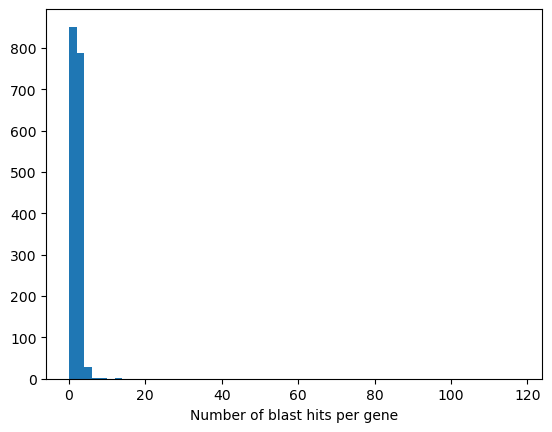

In [11]:
plt.hist(blast_hits["gene_species_name"].value_counts(), bins=np.arange(0,120,2))
plt.xlabel("Number of blast hits per gene")

In [12]:
# Sorts first on species, then on evalue (smallest first)
blast_hits = blast_hits.sort_values(["gene_species_name", "evalue"])

# Only keep the most significant blast hit
top_blast_hit = blast_hits.drop_duplicates("gene_species_name", keep="first")
top_blast_hit

,gene_species_name,blast_hit_gene_name,percent_identical,alignment_length,num_mismatch,num_gaps,start_of_align_query,end_of_align_query,start_of_align_subj,end_of_align_subj,evalue,bitscore
17,YOL108C_saccharomyces_cerevisiae.sgd,g002079.m1,100.000,60,0,0,1,60,1,60,1.310000e-36,117.0
2383,g000004.m1_candida_dubliniensis.final,g003839.m1,25.203,369,159,19,29,354,10,304,1.880000e-04,40.4
1103,g000005.m1_yHMPu5000034682_blastobotrys_arbusc...,g002079.m1,45.455,66,36,0,53,118,41,106,1.530000e-12,58.9
263,g000006.m1_yHMPu5000037240_candida_sp_210210.f...,g002079.m1,46.875,64,34,0,41,104,41,104,2.660000e-12,58.2
1572,g000008.m1_yHMPu5000037255_wickerhamiella_qili...,g002079.m1,45.763,59,32,0,21,79,47,105,1.990000e-12,57.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2237,g012466.m1_yHMPu5000035267_wickerhamomyces_lyn...,g002988.m1,32.292,96,48,3,251,329,252,347,6.000000e-03,36.2
1961,g013856.m1_yHMPu5000035263_Candida_solani_SPAD...,g002079.m1,50.000,34,17,0,273,306,39,72,2.300000e-04,38.9
1980,g015009.m1_yHMPu5000035269_wickerhamomyces_cif...,g002079.m1,28.788,66,47,0,322,387,41,106,1.000000e-03,37.4
2226,g015489.m1_yHMPu5000034630_Magnusiomyces_magnu...,g002079.m1,48.571,35,18,0,153,187,41,75,1.510000e-04,39.3


In [13]:
# Filter for genes with top blast hit to Ino4
top_blast_hit_ino4 = top_blast_hit[top_blast_hit["blast_hit_gene_name"] == "g002079.m1"]
top_blast_hit_ino4

,gene_species_name,blast_hit_gene_name,percent_identical,alignment_length,num_mismatch,num_gaps,start_of_align_query,end_of_align_query,start_of_align_subj,end_of_align_subj,evalue,bitscore
17,YOL108C_saccharomyces_cerevisiae.sgd,g002079.m1,100.000,60,0,0,1,60,1,60,1.310000e-36,117.0
1103,g000005.m1_yHMPu5000034682_blastobotrys_arbusc...,g002079.m1,45.455,66,36,0,53,118,41,106,1.530000e-12,58.9
263,g000006.m1_yHMPu5000037240_candida_sp_210210.f...,g002079.m1,46.875,64,34,0,41,104,41,104,2.660000e-12,58.2
1572,g000008.m1_yHMPu5000037255_wickerhamiella_qili...,g002079.m1,45.763,59,32,0,21,79,47,105,1.990000e-12,57.0
581,g000009.m1_yHMPu5000034680_blastobotrys_adenin...,g002079.m1,44.444,72,39,1,79,149,41,112,2.870000e-15,67.0
...,...,...,...,...,...,...,...,...,...,...,...,...
757,g011041.m1_yHMPu5000035267_wickerhamomyces_lyn...,g002079.m1,39.726,73,40,1,38,110,41,109,3.820000e-10,52.4
1961,g013856.m1_yHMPu5000035263_Candida_solani_SPAD...,g002079.m1,50.000,34,17,0,273,306,39,72,2.300000e-04,38.9
1980,g015009.m1_yHMPu5000035269_wickerhamomyces_cif...,g002079.m1,28.788,66,47,0,322,387,41,106,1.000000e-03,37.4
2226,g015489.m1_yHMPu5000034630_Magnusiomyces_magnu...,g002079.m1,48.571,35,18,0,153,187,41,75,1.510000e-04,39.3


In [14]:
# Merge blast df with filtered domain df
top_blast_hit_ino4 = top_blast_hit_ino4.merge(dna_binding_domain, left_on="gene_species_name", right_on="name")

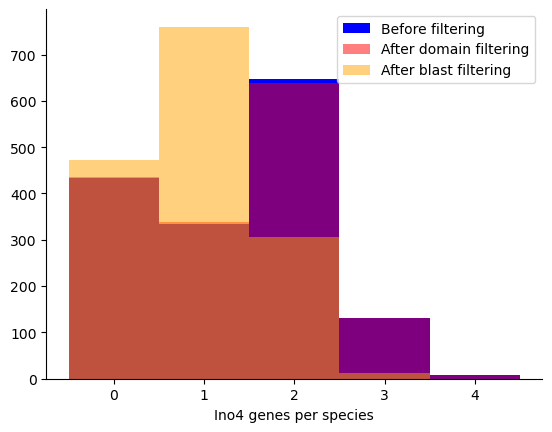

In [38]:
# Visualize genes per species
plt.hist(genes_species["species"].value_counts(), bins=[0.5, 1.5, 2.5, 3.5, 4.5], label="Before filtering", color="blue")
plt.hist([0] * (1553 - len(set(genes_species["species"]))) , bins=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5], color="blue")

plt.hist(dna_binding_domain["species"].value_counts(), bins=[0.5, 1.5, 2.5, 3.5, 4.5], alpha=0.5, label="After domain filtering", color='red')
plt.hist([0] * (1553 - len(set(dna_binding_domain["species"]))), bins=[-0.5,0.5, 1.5, 2.5, 3.5, 4.5], alpha=0.5, color='red')


plt.hist(top_blast_hit_ino4.value_counts("species"), bins=[0.5, 1.5, 2.5, 3.5], label="After blast filtering", alpha=0.5, color='orange')
plt.hist([0] * (1553 - len(set(top_blast_hit_ino4["species"]))), bins=[-0.5,0.5, 1.5, 2.5, 3.5], alpha=0.5, color='orange')

ax = plt.gca() 
ax.spines['right'].set_visible(False) 
ax.spines['top'].set_visible(False) 

plt.xticks([0, 1,2,3,4])
plt.xlabel("Ino4 genes per species")
plt.legend()

In [16]:
# Read fasta sequences
with open("../Ino4/Ino4_orthologs.fasta", "r") as f:
    lines = f.readlines()

seqs = []
names = []
seq = ""

for line in lines:
    if line.startswith('>'):
        names.append(line.strip().replace(">", ""))
        if len(seq) > 0:
            seqs.append(seq)
            seq = ""
    else:
        seq += line.strip()
seqs.append(seq)

# Write to a csv file
ino4_df = pd.DataFrame({"name" : names, "aa_seq" : seqs})
ino4_df.to_csv("../Ino4/Ino4_orthologs.csv", index=False)
ino4_df

,name,aa_seq
0,g000082.m1_yHDO603_zygosaccharomyces_sapae_190...,MVVKLREIKSNGSIRNIHNSMQLDDVDADVRRQRDESEELLRKKRK...
1,g001507.m1_yHMPu5000034863_zygosaccharomyces_r...,MVVKLREIKSNGSIRNIHNSMQLDDVDADVRRQRDESEELLRKKRK...
2,g002198.m1_yHDO572_zygosaccharomyces_mellis_18...,MEVELRGVKNNNDHSIHNSMQLNDEDVNTRRQRDENEEPLRKKRKP...
3,g006183.m1_yHDO603_zygosaccharomyces_sapae_190...,MVVKLREIKSNSSNTRSTPDNMQLDGEDIDARGQRDENEEPLKKKR...
4,g004475.m1_yHMPu5000037836_zygosaccharomyces_p...,MVVKLREIKSNSSNTRSTPDNMQLDGEDIDARGQRDENEEPLKKKR...
...,...,...
2046,g002210.m1_yHMPu5000041772_sugiyamaella_chiloe...,MDLKDIVTATSGLHTSTPKVSTGNGSTRSTGLVSPDTSGGTLTVGP...
2047,g003709.m1_yHMPu5000037918_alloascoidea_africa...,MLMIPRQIPKLPSFEAVRQSVNSLDCINSNSNNNSNSSNPFNISNL...
2048,g005186.m1_yHMPu5000035679_candida_rhagii_1606...,MSHNLSKPENLSEFNSPNPNNFEFPVHTQDLSHIQQTIANSNFSLD...
2049,g005901.m1_yHMPu5000035680_candida_pseudorhagi...,MSHNLSKPENLSEFNSPNPNNFEFPVHTQDLSHIQQTIANSNFSLD...


In [17]:
# Merge sequence df with filtered df
ino4_filtered_df = ino4_df.merge(top_blast_hit_ino4, left_on="name", right_on="gene_species_name")
ino4_filtered_df

,name_x,aa_seq,gene_species_name,blast_hit_gene_name,percent_identical,alignment_length,num_mismatch,num_gaps,start_of_align_query,end_of_align_query,...,Hit type,PSSM-ID,From,To,E-Value,Bitscore,Accession,Short name,Incomplete,Superfamily
0,g000082.m1_yHDO603_zygosaccharomyces_sapae_190...,MVVKLREIKSNGSIRNIHNSMQLDDVDADVRRQRDESEELLRKKRK...,g000082.m1_yHDO603_zygosaccharomyces_sapae_190...,g002079.m1,45.536,112,43,2,52,147,...,superfamily,469605,59,125,5.74237e-22,85.2086,cl00081,bHLH_SF superfamily,-,-
1,g001507.m1_yHMPu5000034863_zygosaccharomyces_r...,MVVKLREIKSNGSIRNIHNSMQLDDVDADVRRQRDESEELLRKKRK...,g001507.m1_yHMPu5000034863_zygosaccharomyces_r...,g002079.m1,45.536,112,43,2,52,147,...,superfamily,469605,59,125,5.74237e-22,85.2086,cl00081,bHLH_SF superfamily,-,-
2,g002198.m1_yHDO572_zygosaccharomyces_mellis_18...,MEVELRGVKNNNDHSIHNSMQLNDEDVNTRRQRDENEEPLRKKRKP...,g002198.m1_yHDO572_zygosaccharomyces_mellis_18...,g002079.m1,46.364,110,45,2,51,146,...,superfamily,469605,58,124,1.13336e-24,92.1421,cl00081,bHLH_SF superfamily,-,-
3,g006183.m1_yHDO603_zygosaccharomyces_sapae_190...,MVVKLREIKSNSSNTRSTPDNMQLDGEDIDARGQRDENEEPLKKKR...,g006183.m1_yHDO603_zygosaccharomyces_sapae_190...,g002079.m1,47.273,110,44,2,53,148,...,superfamily,469605,60,126,5.73487e-24,89.8309,cl00081,bHLH_SF superfamily,-,-
4,g004475.m1_yHMPu5000037836_zygosaccharomyces_p...,MVVKLREIKSNSSNTRSTPDNMQLDGEDIDARGQRDENEEPLKKKR...,g004475.m1_yHMPu5000037836_zygosaccharomyces_p...,g002079.m1,47.273,110,44,2,53,148,...,superfamily,469605,60,126,5.49291e-24,89.8309,cl00081,bHLH_SF superfamily,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1414,g000775.m1_yHMPu5000034896_ogataea_dorogensis_...,MSVKKLPSNTKSPTPGLLTPIFSALPTQENYHPAAASTTWANPEQE...,g000775.m1_yHMPu5000034896_ogataea_dorogensis_...,g002079.m1,47.059,34,18,0,249,282,...,superfamily,469605,253,329,7.0193e-08,48.9998,cl00081,bHLH_SF superfamily,-,-
1415,g001022.m1_yHMPu5000034947_ambrosiozyma_philen...,MPMENSRPPPSQMFVPNSNLSPAIISQQQRPIDNDPLSDYFSTDMD...,g001022.m1_yHMPu5000034947_ambrosiozyma_philen...,g002079.m1,47.059,34,18,0,375,408,...,superfamily,469605,379,416,5.30185e-08,49.7702,cl00081,bHLH_SF superfamily,C,-
1416,g000965.m1_yHMH407_Schwanniomyces_sp_nov_plate...,MITKDIPEVGQLVSGFTNKSKHHSSENNNSVNHNSKVNKSPYTVTA...,g000965.m1_yHMH407_Schwanniomyces_sp_nov_plate...,g002079.m1,28.571,98,59,2,485,573,...,superfamily,469605,489,575,0.000193386,39.755,cl00081,bHLH_SF superfamily,-,-
1417,g004369.m1_yHMPu5000035242_zygoascus_ofunaensi...,MTTKPDPISGKRRRSSSSVSSLVSMDLTTTTTSVNAIQDMHLRPQP...,g004369.m1_yHMPu5000035242_zygoascus_ofunaensi...,g002079.m1,32.911,79,37,3,439,514,...,superfamily,469605,438,513,9.7756e-13,63.0878,cl00081,bHLH_SF superfamily,-,-


In [18]:
# Write filtered data to csv
ino4_filtered_df.to_csv("../Ino4/Ino4_blast_filtered.csv", index=False)

In [19]:
# Write filtered sequences to fasta
with open("../Ino4/Ino4_blast_filtered.fasta", "w+") as f:
    for i in ino4_filtered_df.index:
        f.write(">" + ino4_filtered_df.loc[i, "name_x"] + "\n")
        f.write(ino4_filtered_df.loc[i, "aa_seq"] + "\n")

### Run ADHunter on sequences to predict activation domain

# Make alignment conservation plot

In [20]:
# Read in ADHunter predicted activities
predictions = pd.read_csv('../Ino4/ADhunter_preds.csv', converters={'adhunter_centers':pd.eval, 'adhunter_preds':pd.eval})
predictions

,sequence,adhunter_centers,adhunter_preds
0,MVVKLREIKSNGSIRNIHNSMQLDDVDADVRRQRDESEELLRKKRK...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[12539.0517578125, 20987.10546875, 19128.71484..."
1,MVVKLREIKSNGSIRNIHNSMQLDDVDADVRRQRDESEELLRKKRK...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[12539.0517578125, 20987.10546875, 19128.71484..."
2,MEVELRGVKNNNDHSIHNSMQLNDEDVNTRRQRDENEEPLRKKRKP...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[14734.2705078125, 13786.0712890625, 13229.168..."
3,MVVKLREIKSNSSNTRSTPDNMQLDGEDIDARGQRDENEEPLKKKR...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[9442.6259765625, 7818.1923828125, 11797.20019..."
4,MVVKLREIKSNSSNTRSTPDNMQLDGEDIDARGQRDENEEPLKKKR...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[9442.6259765625, 7818.1923828125, 11797.20019..."
...,...,...,...
1414,MSVKKLPSNTKSPTPGLLTPIFSALPTQENYHPAAASTTWANPEQE...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[45455.421875, 48668.19921875, 48247.3515625, ..."
1415,MPMENSRPPPSQMFVPNSNLSPAIISQQQRPIDNDPLSDYFSTDMD...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[26072.03515625, 46581.25, 47426.46484375, 477..."
1416,MITKDIPEVGQLVSGFTNKSKHHSSENNNSVNHNSKVNKSPYTVTA...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[27596.5625, 26060.45703125, 28153.328125, 287..."
1417,MTTKPDPISGKRRRSSSSVSSLVSMDLTTTTTSVNAIQDMHLRPQP...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[40680.4609375, 40230.21875, 40979.38671875, 3..."


In [21]:
predictions["Length"] = predictions["sequence"].str.len()

In [22]:
# Get location of maximum activity --> Assume this is part of an AD
predictions["max_adhunter_pred"] = [np.max(i) for i in predictions['adhunter_preds']]
max_centers = []

for i in predictions.index:
    max_val = predictions.loc[i,"max_adhunter_pred"]

    # Get the index of the maximum predicted value
    max_idx = predictions.loc[i,"adhunter_preds"].index(max_val)
    
    # Get the corresponding amino acid residue position for that maximum value
    max_center = predictions.loc[i,"adhunter_centers"][max_idx]
    max_centers.append(max_center)

# Save locations of maximum activity values
predictions["max_adhunter_center"] = max_centers
predictions

,sequence,adhunter_centers,adhunter_preds,Length,max_adhunter_pred,max_adhunter_center
0,MVVKLREIKSNGSIRNIHNSMQLDDVDADVRRQRDESEELLRKKRK...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[12539.0517578125, 20987.10546875, 19128.71484...",214,55182.738281,122.0
1,MVVKLREIKSNGSIRNIHNSMQLDDVDADVRRQRDESEELLRKKRK...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[12539.0517578125, 20987.10546875, 19128.71484...",214,55182.738281,122.0
2,MEVELRGVKNNNDHSIHNSMQLNDEDVNTRRQRDENEEPLRKKRKP...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[14734.2705078125, 13786.0712890625, 13229.168...",207,69086.859375,121.0
3,MVVKLREIKSNSSNTRSTPDNMQLDGEDIDARGQRDENEEPLKKKR...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[9442.6259765625, 7818.1923828125, 11797.20019...",200,99279.437500,125.0
4,MVVKLREIKSNSSNTRSTPDNMQLDGEDIDARGQRDENEEPLKKKR...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[9442.6259765625, 7818.1923828125, 11797.20019...",200,99279.437500,125.0
...,...,...,...,...,...,...
1414,MSVKKLPSNTKSPTPGLLTPIFSALPTQENYHPAAASTTWANPEQE...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[45455.421875, 48668.19921875, 48247.3515625, ...",330,230624.187500,44.0
1415,MPMENSRPPPSQMFVPNSNLSPAIISQQQRPIDNDPLSDYFSTDMD...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[26072.03515625, 46581.25, 47426.46484375, 477...",466,194404.984375,34.0
1416,MITKDIPEVGQLVSGFTNKSKHHSSENNNSVNHNSKVNKSPYTVTA...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[27596.5625, 26060.45703125, 28153.328125, 287...",576,203739.593750,186.0
1417,MTTKPDPISGKRRRSSSSVSSLVSMDLTTTTTSVNAIQDMHLRPQP...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[40680.4609375, 40230.21875, 40979.38671875, 3...",525,175644.984375,105.0


Text(0.5, 0, 'Relative position of maximum ADHunter activity')

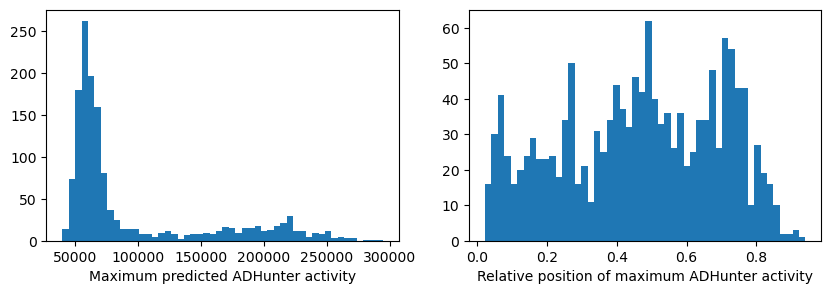

In [23]:
# Visualize location and distribution of maximum activities
fig, axs = plt.subplots(1,2,figsize=(10,3))
axs[0].hist(predictions["max_adhunter_pred"], bins=50)
axs[0].set_xlabel("Maximum predicted ADHunter activity")

axs[1].hist(predictions["max_adhunter_center"]/predictions["Length"], bins=50)
axs[1].set_xlabel("Relative position of maximum ADHunter activity")

Text(0.5, 0, 'Relative position of maximum ADHunter activity')

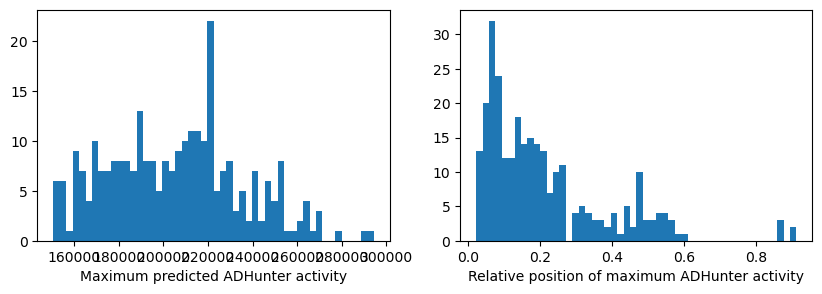

In [24]:
# Visualize location and distribution of maximum activities for only the active sequences
fig, axs = plt.subplots(1,2,figsize=(10,3))
axs[0].hist(predictions[predictions["max_adhunter_pred"] > 150000]["max_adhunter_pred"], bins=50)
axs[0].set_xlabel("Maximum predicted ADHunter activity")

axs[1].hist(predictions[predictions["max_adhunter_pred"] > 150000]["max_adhunter_center"]/predictions["Length"], bins=50)
axs[1].set_xlabel("Relative position of maximum ADHunter activity")

In [25]:
# Code to get a 70aa region around the maximum predicted ADHunter activity
def get_high_activity_region(sequence, max_center):
    
    # If the max activity is 35aa or more away from both ends
    if (len(sequence) >= max_center + 35) & (max_center - 35 >= 0):
        region = sequence[max_center - 35 : max_center + 35]
    
     # If the max activity is close to the end
    elif (len(sequence) < max_center + 35):
        region = sequence[len(sequence)-70:]
    
    # If the max activity is close to the beginning
    else:
        region = sequence[:70]
    return region

In [26]:
# Extract AD regions for all sequences
predictions["AD_region"] = [get_high_activity_region(predictions.loc[i, "sequence"], int(predictions.loc[i, "max_adhunter_center"])) for i in predictions.index]

In [27]:
# Merge ADHunter predictions with filtered df
predictions_w_names = ino4_filtered_df.merge(predictions.drop_duplicates("sequence"), left_on="aa_seq", right_on="sequence")
predictions_w_names

,name_x,aa_seq,gene_species_name,blast_hit_gene_name,percent_identical,alignment_length,num_mismatch,num_gaps,start_of_align_query,end_of_align_query,...,Short name,Incomplete,Superfamily,sequence,adhunter_centers,adhunter_preds,Length,max_adhunter_pred,max_adhunter_center,AD_region
0,g000082.m1_yHDO603_zygosaccharomyces_sapae_190...,MVVKLREIKSNGSIRNIHNSMQLDDVDADVRRQRDESEELLRKKRK...,g000082.m1_yHDO603_zygosaccharomyces_sapae_190...,g002079.m1,45.536,112,43,2,52,147,...,bHLH_SF superfamily,-,-,MVVKLREIKSNGSIRNIHNSMQLDDVDADVRRQRDESEELLRKKRK...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[12539.0517578125, 20987.10546875, 19128.71484...",214,55182.738281,122.0,DLQPTENRSEMVIYLKTINHLNWLYRNNKRLCAQLEKKYKELGKDG...
1,g001507.m1_yHMPu5000034863_zygosaccharomyces_r...,MVVKLREIKSNGSIRNIHNSMQLDDVDADVRRQRDESEELLRKKRK...,g001507.m1_yHMPu5000034863_zygosaccharomyces_r...,g002079.m1,45.536,112,43,2,52,147,...,bHLH_SF superfamily,-,-,MVVKLREIKSNGSIRNIHNSMQLDDVDADVRRQRDESEELLRKKRK...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[12539.0517578125, 20987.10546875, 19128.71484...",214,55182.738281,122.0,DLQPTENRSEMVIYLKTINHLNWLYRNNKRLCAQLEKKYKELGKDG...
2,g002198.m1_yHDO572_zygosaccharomyces_mellis_18...,MEVELRGVKNNNDHSIHNSMQLNDEDVNTRRQRDENEEPLRKKRKP...,g002198.m1_yHDO572_zygosaccharomyces_mellis_18...,g002079.m1,46.364,110,45,2,51,146,...,bHLH_SF superfamily,-,-,MEVELRGVKNNNDHSIHNSMQLNDEDVNTRRQRDENEEPLRKKRKP...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[14734.2705078125, 13786.0712890625, 13229.168...",207,69086.859375,121.0,DLQPSENRSEMVIYLKTINHLNWLYRTNKRLCNQLEKKYKELGEDG...
3,g006183.m1_yHDO603_zygosaccharomyces_sapae_190...,MVVKLREIKSNSSNTRSTPDNMQLDGEDIDARGQRDENEEPLKKKR...,g006183.m1_yHDO603_zygosaccharomyces_sapae_190...,g002079.m1,47.273,110,44,2,53,148,...,bHLH_SF superfamily,-,-,MVVKLREIKSNSSNTRSTPDNMQLDGEDIDARGQRDENEEPLKKKR...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[9442.6259765625, 7818.1923828125, 11797.20019...",200,99279.437500,125.0,QPSENRSEMVIYLKTINHLNWLYRNNKRLCGQLEKKYKELGKDDYR...
4,g004475.m1_yHMPu5000037836_zygosaccharomyces_p...,MVVKLREIKSNSSNTRSTPDNMQLDGEDIDARGQRDENEEPLKKKR...,g004475.m1_yHMPu5000037836_zygosaccharomyces_p...,g002079.m1,47.273,110,44,2,53,148,...,bHLH_SF superfamily,-,-,MVVKLREIKSNSSNTRSTPDNMQLDGEDIDARGQRDENEEPLKKKR...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[9442.6259765625, 7818.1923828125, 11797.20019...",200,99279.437500,125.0,QPSENRSEMVIYLKTINHLNWLYRNNKRLCGQLEKKYKELGKDDYR...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1414,g000775.m1_yHMPu5000034896_ogataea_dorogensis_...,MSVKKLPSNTKSPTPGLLTPIFSALPTQENYHPAAASTTWANPEQE...,g000775.m1_yHMPu5000034896_ogataea_dorogensis_...,g002079.m1,47.059,34,18,0,249,282,...,bHLH_SF superfamily,-,-,MSVKKLPSNTKSPTPGLLTPIFSALPTQENYHPAAASTTWANPEQE...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[45455.421875, 48668.19921875, 48247.3515625, ...",330,230624.187500,44.0,TKSPTPGLLTPIFSALPTQENYHPAAASTTWANPEQEPLDYFSTDL...
1415,g001022.m1_yHMPu5000034947_ambrosiozyma_philen...,MPMENSRPPPSQMFVPNSNLSPAIISQQQRPIDNDPLSDYFSTDMD...,g001022.m1_yHMPu5000034947_ambrosiozyma_philen...,g002079.m1,47.059,34,18,0,375,408,...,bHLH_SF superfamily,C,-,MPMENSRPPPSQMFVPNSNLSPAIISQQQRPIDNDPLSDYFSTDMD...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[26072.03515625, 46581.25, 47426.46484375, 477...",466,194404.984375,34.0,MPMENSRPPPSQMFVPNSNLSPAIISQQQRPIDNDPLSDYFSTDMD...
1416,g000965.m1_yHMH407_Schwanniomyces_sp_nov_plate...,MITKDIPEVGQLVSGFTNKSKHHSSENNNSVNHNSKVNKSPYTVTA...,g000965.m1_yHMH407_Schwanniomyces_sp_nov_plate...,g002079.m1,28.571,98,59,2,485,573,...,bHLH_SF superfamily,-,-,MITKDIPEVGQLVSGFTNKSKHHSSENNNSVNHNSKVNKSPYTVTA...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[27596.5625, 26060.45703125, 28153.328125, 287...",576,203739.593750,186.0,FLKENNPLDRQQPESLGNTGDSDYNFFTLDMVTEDMDFEQAYSTYT...
1417,g004369.m1_yHMPu5000035242_zygoascus_ofunaensi...,MTTKPDPISGKRRRSSSSVSSLVSMDLTTTTTSVN

In [28]:
# Make fasta file with only the ADregions
with open("../Ino4/Ino4_filtered_ADregions.fasta", "w+") as f:
    for i in predictions_w_names.index:
        f.write(">" + predictions_w_names.loc[i, "gene_species_name"] + "\n")
        f.write(predictions_w_names.loc[i, "AD_region"] + "\n")

In [29]:
# Colors for the alignment conservation plots
amino_acid_colors = {
    # Purples
    'F': '#FFA442',  
    'W': '#006CAF',
    'L': '#5B2B82',

    # Reds
    'D': '#E03839', 
    'E': '#FDA0A5', 

    # Blues
    'K': '#00B3E5',  
    'R': '#00B3E5',   

    # black
    'S': '#000000',  
    'P': '#000000', 

    # greys
    'A': '#787878',  
    'V': '#787878', 
    'I': '#787878', 
    'M': '#787878',  
    'T': '#787878',  
    'G': '#787878',  
    'C': '#787878', 
    'N': '#787878',  
    'Q': '#787878', 
    'H': '#787878',  
    'Y': '#787878', 
    '-': "#FFFFFF"
}

In [30]:
# Code to make alignment conservation plots
def make_alignment_conservation_plot(alignment_file, output_file, remove_gaps=False):
    
    # Read in alignment file
    with open(alignment_file, "r") as f:
        lines = f.readlines()

    names = []
    seqs = []
    seq = ""

    for line in lines:
        if line.startswith(">"):
            names.append(line.strip().replace(">",""))
            if len(seq) > 0:
                seqs.append(seq)
                seq = ""
        else:
            seq += line.strip()

    seqs.append(seq)

    # This will determine the position of the amino acid in the plot (i.e. X at the bottom, - at the top)
    amino_acids = ['Y', 'H', 'Q','N', 'C', 'G', 'T', 'M', 'I', 'V', 'A', 'S',  'P', 'R', 'K', 'D', 'E', 'L', 'W', 'F', '-']

    # List of sequence positions - Each entry is a dictionary with amino acid counts at the position
    amino_acid_dicts = [{aa: 0 for aa in amino_acids}.copy() for _ in range(len(seqs[0]))]

    # Go through each sequence and count the amino acids at each position
    for seq in seqs: 
        for i, aa in enumerate(seq): 
            amino_acid_dicts[i][aa] += 1
    
    if remove_gaps: 
        filtered_aa_dict = []
        for aa_d in amino_acid_dicts:
            # Only include positions that are less than 90% gaps
            if aa_d['-'] < len(seqs) * .90:
                filtered_aa_dict.append(aa_d)
        amino_acid_dicts = filtered_aa_dict

    from matplotlib.lines import Line2D
    fig, ax = plt.subplots(figsize=(20,3))

    for i, count_dict in enumerate(amino_acid_dicts): 
        bottom = 0

        # Add to the bar for each amino acid
        for aa, count in count_dict.items():
            p = ax.bar(i, count/len(seqs), label=aa, bottom=bottom, color = amino_acid_colors[aa])
            bottom += count/len(seqs)

    ax.set_xlabel("Alignment position")
    ax.set_ylabel("Percent of sequences")

    custom_lines = []

    # Code to add a legend
    for color in list(amino_acid_colors.values()):
        custom_lines.append(Line2D([0], [0], color=color, lw=2))

    ax.legend(custom_lines, list(amino_acid_colors.keys()), bbox_to_anchor=(1.05, 1.05), fontsize=5.5)

    plt.savefig(output_file)

In [65]:
! mafft --auto ../Ino4/Ino4_filtered_ADregions.fasta > ../Ino4/Ino4_filtered_ADregions.mafft

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8176 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
 1401 / 1419
done.

Constructing a UPGMA tree (efffree=0) ... 
 1410 / 1419
done.

Progressive alignment 1/2... 
STEP   218 / 1418 
Reallocating..done. *alloclen = 1143
STEP  1401 / 1418  h
done.

Making a distance matrix from msa.. 
 1400 / 1419
done.

Constructing a UPGMA tree (efffree=1) ... 
 1410 / 1419
done.

Progressive alignment 2/2... 
STEP   496 / 1418 
Reallocating..done. *alloclen = 1142
STEP  1401 / 1418  h
done.

disttbfast (aa) Version 7.526
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-2 (Fast but rough)
 Progressive method (guide trees were built 2 times.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scoring scheme has been changed in version 7.110 (2013 Oct)

In [39]:
! mafft --auto ../Ino4/Ino4_blast_filtered.fasta > ../Ino4/Ino4_blast_filtered.mafft

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8176 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
 1401 / 1419
done.

Constructing a UPGMA tree (efffree=0) ... 
 1410 / 1419
done.

Progressive alignment 1/2... 
STEP  1201 / 1418 
Reallocating..done. *alloclen = 4616
STEP  1301 / 1418 
Reallocating..done. *alloclen = 6152

Reallocating..done. *alloclen = 8413
STEP  1401 / 1418 
done.

Making a distance matrix from msa.. 
 1400 / 1419
done.

Constructing a UPGMA tree (efffree=1) ... 
 1410 / 1419
done.

Progressive alignment 2/2... 
STEP  1101 / 1418 
Reallocating..done. *alloclen = 4505
STEP  1301 / 1418 
Reallocating..done. *alloclen = 6969

Reallocating..done. *alloclen = 8348
STEP  1401 / 1418  h
Reallocating..done. *alloclen = 9392

done.

disttbfast (aa) Version 7.526
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-2 (Fast but rough)
 Progressive method (guide trees were built 2 tim

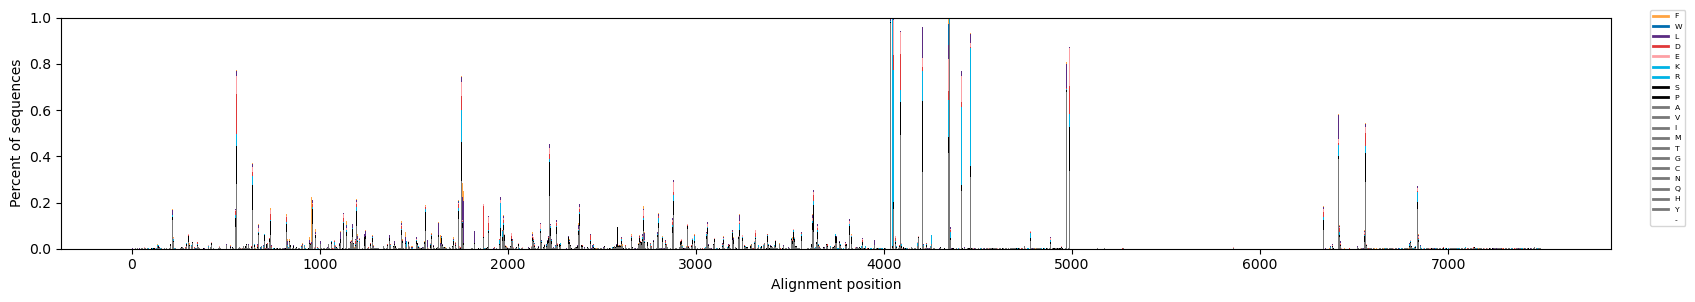

In [40]:
make_alignment_conservation_plot("../Ino4/Ino4_blast_filtered.mafft", "../Ino4/Ino4_full_alignment_conservation_plot.pdf")

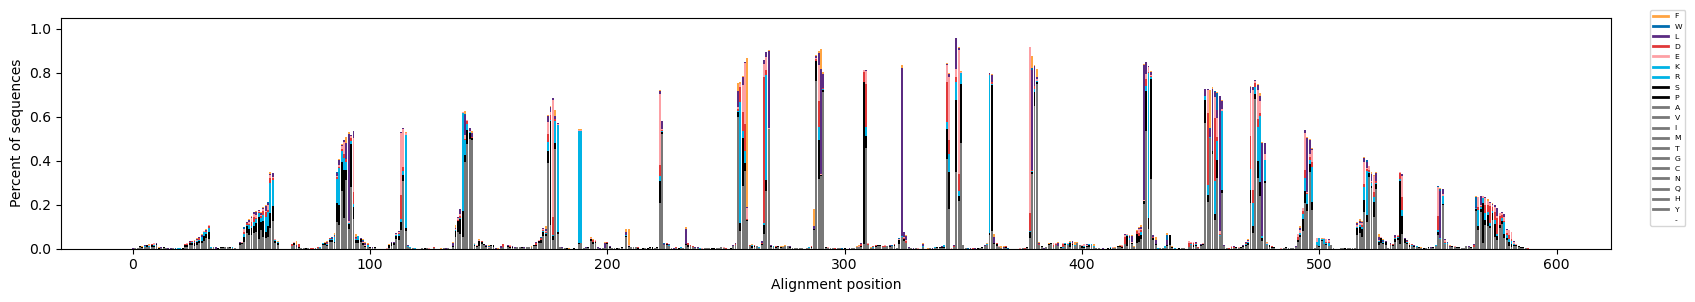

In [31]:
make_alignment_conservation_plot("../Ino4/Ino4_filtered_ADregions.mafft", "../Ino4/Ino4_ADregions_alignment_conservation_plot.pdf")

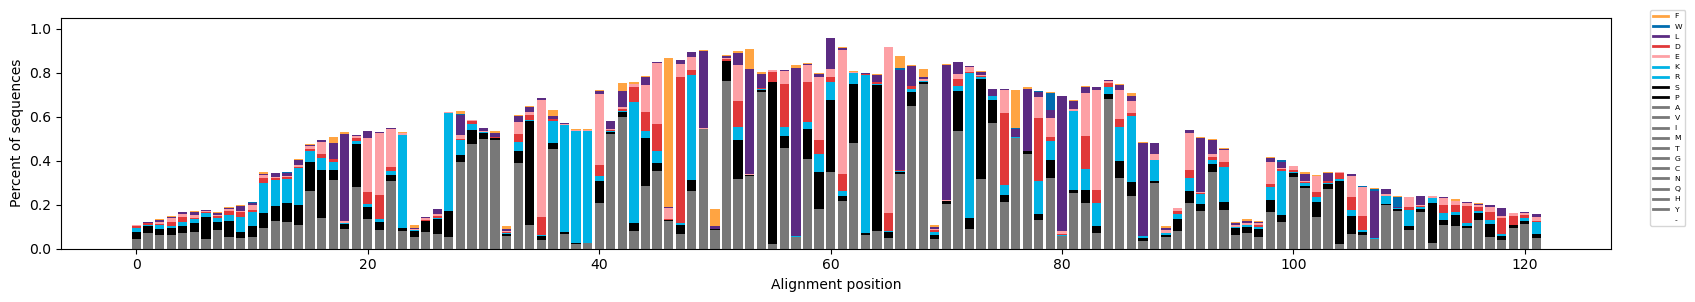

In [31]:
make_alignment_conservation_plot("../Ino4/Ino4_filtered_ADregions.mafft", "../Ino4/Ino4_ADregions_alignment_conservation_plot_no_gaps.pdf", remove_gaps=True)